In [ ]:
import sys
sys.path.append("../src")

import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from decision import apply_threshold
from config import evaluation_config

#Load pipeline correctly
pipeline = joblib.load("../models/churn_pipeline.pkl")
preprocessor = pipeline.named_steps["preprocess"]
model = pipeline.named_steps["model"]

In [2]:
# Load Data
df = pd.read_csv("../data/raw/Telco-Customer-Churn.csv")

X_raw = df.drop(columns=["Churn"])
y = df["Churn"]

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_raw,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Map y_test once here for all metric functions
y_test_mapped = y_test.map({"Yes": 1, "No": 0})

In [ ]:
# Predict using full pipeline (handles preprocessing internally)
y_proba = pipeline.predict_proba(X_test)[:, 1]
y_pred = apply_threshold(y_proba, evaluation_config.decision_threshold)

print(f"y_proba shape: {y_proba.shape}")
print(f"y_pred shape: {y_pred.shape}")

y_proba shape: (1409,)
y_pred shape: (1409,)


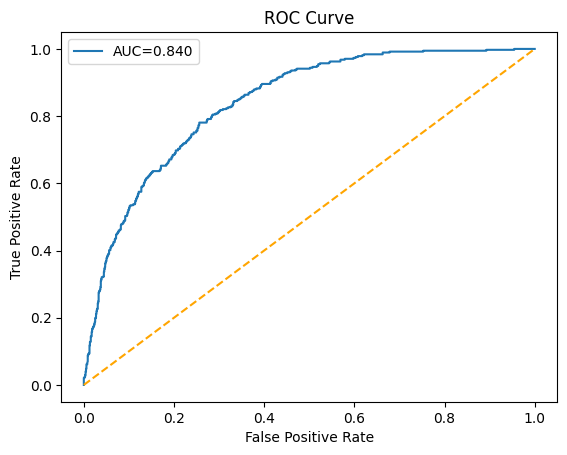

In [5]:
# ROC Curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test_mapped, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

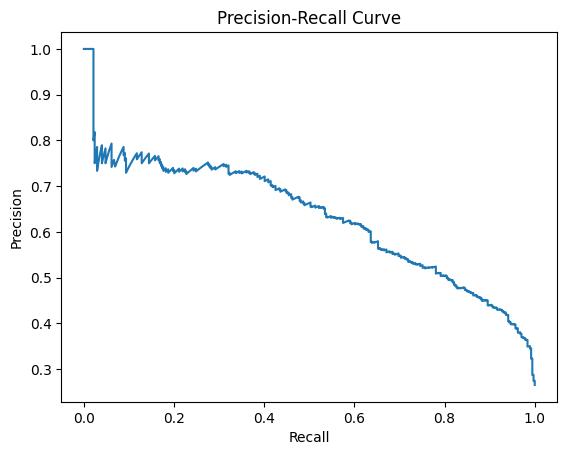

In [6]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test_mapped, y_proba)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

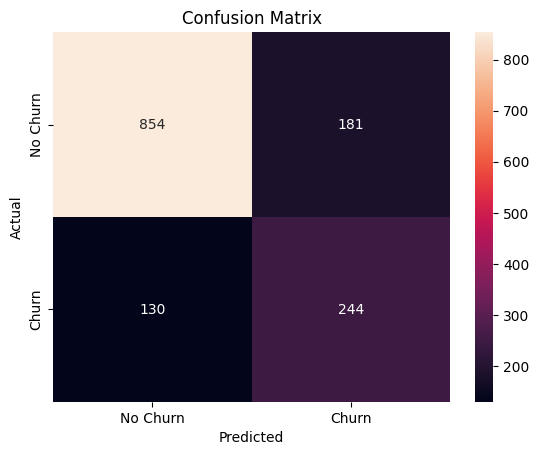

In [7]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_mapped, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["No Churn", "Churn"],
            yticklabels=["No Churn", "Churn"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## Interpretation

**Precision vs Recall Trade-off:**
- Higher threshold → higher precision, lower recall (fewer false alarms, miss more churners)
- Lower threshold → higher recall, lower precision (catch more churners, more false alarms)
- Threshold was tuned by testing 0.3, 0.4, and 0.5 against the confusion matrix

**Threshold Tuning:**
- At 0.5: Recall 54.8%, Precision 63.5% — too many missed churners (169)
- At 0.3: Recall 74.9%, Precision 52.6% — too many false alarms (252)
- At 0.4: Recall 65.2%, Precision 57.4% — best balance  (selected)

**Confusion Matrix at Threshold 0.4:**
- 244 churners correctly identified (True Positives)
- 130 churners missed (False Negatives) — customers lost without intervention
- 181 non-churners flagged incorrectly (False Positives) — unnecessary retention offers
- 854 non-churners correctly dismissed (True Negatives)

**Business Implications:**
- **False Negative** (missed churner) = lost customer, lost revenue — high cost
- **False Positive** (wrongly flagged) = unnecessary retention offer sent — low cost
- Threshold 0.4 was chosen because catching 39 more churners than 0.5 outweighs the cost of 63 extra retention offers
- Final threshold set to `decision_threshold = 0.4` in config